# Diffusion maps for single-cell data analysis

By means of this notebook, you can solve all the programming tasks of chapter 4. You can download all the needed files (data1.mat and guo.xlsx) from the homepage. 

In [1]:
%matplotlib inline
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
import numpy.linalg as LA
import mllab.pca
from scipy.io import loadmat 
from pandas import read_excel
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

#add here your required imports

In [ ]:
#test cell



## Introduction
#### Task 1: Implement the diffusion maps algorithm.
It is recommended to solve this task by defining a class for diffusion maps and implement a fit_transform function, which returns the embedding of a given data set. This standardizes the code when comparing diffusion maps with other dimensionality reduction methods.

In [ ]:
# your code goes here

In [9]:
class DiffMap():
    """
    Class Diffusion Maps
    
    Parameters
    ----------
    n_comp: int, optional, default = None
        number of dimensions in which the data will be embedded
    sigma: optional, default = 10
        bandwidth of the Gaussian kernel
    alpha: optional, default = 1
        the density rescaling parameter
    """
    
    def __init__(self, n_components = None, sigma = 10, alpha = 1):
        self.ndim = n_components
        self.sigma = sigma
        self.alpha = alpha
        
        self.evals = None
        self.evecs = None
    
            
    def fit_transform(self, X):
        """
        Computes the embedding
        
        Parameters
        ----------
        X: array
           input data
           
        Returns
        -------
        evecs: array [n_cells, n_comp]
            array of n_comp eigenvectors or diffusion coordinates
        """
        # your code goes here
        
        #compute transition matrix
        K = np.exp(-cdist(X,X, 'sqeuclidean')/(2*self.sigma*self.sigma))
        Q_minus_alpha = np.diag(np.power(np.sum(K, axis=1),-self.alpha))
        K_alpha = Q_minus_alpha @ K @ Q_minus_alpha 
        np.fill_diagonal(K_alpha, 0)
        D_alpha_inv = np.diag(1/np.sum(K_alpha,axis=1))
        P = D_alpha_inv @ K_alpha
        
        #compute eigenvectors and eigenvalues
        self.evals, self.evecs = LA.eig(P)
        sorted_indices = np.flip(np.argsort(self.evals),0)
        self.evals = self.evals[sorted_indices]
        self.evecs = self.evecs[sorted_indices]
        
        #if ndim is not given, compute it using spectral clustering
        if self.ndim is None:
            self.ndim = np.argmax(self.evals[:-1]-self.evals[1:])
            
        return self.evecs[:,1:self.ndim+1] * self.evals[1:self.ndim+1]
        

#### Task 2: Perform a diffusion map analysis on the Buettner data set. 

In [3]:
def load_buettner_data(): 
    #load buettner data
    file = loadmat('data//data1.mat')
    data = file.get('in_X')
    data = np.array(data)

    #group assignments
    labels = file.get('true_labs')
    labels = labels[:,0] -1
 
    #group names
    stage_names = ['1', '2', '3']

    return data, stage_names, labels

In [10]:
# your code goes here
data, stage_names, labels = load_buettner_data()
clf = DiffMap(n_components=3,sigma=20)
data_reduced = clf.fit_transform(data)

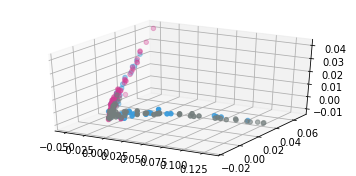

In [11]:
# your code goes here
mllab.pca.plot_toy_3d(data_reduced,labels)

#### Task 3: Perform a PCA analysis of the Buettner data set.

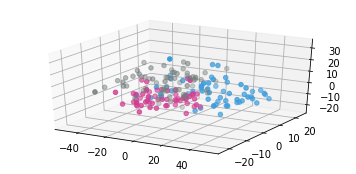

In [12]:
# your code goes here
pca = PCA(3)
mllab.pca.plot_toy_3d(pca.fit_transform(data),labels)

## Single-cell data analysis

In the following, we will apply diffusion maps to the Guo data. In the file, you will find some necessary information:

1. the input data, which is a matrix with a certain number of cells as row number and a certain number of genes as column number,
2. the names of the measured genes and
3. an assignment of each cell to an embryonic stage. These assignments have to be converted into numerical labels to use them for the scatter plots.

### Pre-processing
#### Task 4: Pre-process the Guo data.

Take a look at the file guo.xlsx. The naming annotation in the first column refers to the embryonic stage, embryo number, and individual cell number, thus 64C 2.7 refers to the 7th cell harvested from the 2nd embryo collected from the 64-cell stage. In the first row, you will find the names of the measured genes.

In [13]:
def load_guo_data():
    #load guo data
    data_frame = read_excel('data//guo.xlsx', sheet_name = 'Sheet1')

    #data
    adata = data_frame.as_matrix()
    data = adata[:,1:]
    embryonic_stages = adata[:,0]

    #genes
    genes_tmp = data_frame.axes[1][1:]
    genes_names = [genes_tmp[k] for k in range(genes_tmp.size)]

    # your code goes here
    data = data[9:,:]
    mask1 = np.sum(data > 28, axis = 1) == 0
    data = data[mask1]

    mean = np.matlib.repmat(.5*(data[:,0]+data[:,15]), data.shape[1], 1).T
    mask2 = data != 28
    data_normalized = data - np.where(mask2, mean, 0)
    
    maximum = np.amax(data_normalized[mask2])
    data_normalized[~mask2] = np.ceil(maximum)
    data_normalized = data_normalized.astype(np.double)
    np.round(data_normalized,3)
    
    
    #stage_names and creating labels
    stage_names = ['1C', '2C', '4C', '8C', '16C', '32C', '64C']

    labels = np.array([next(np.where([name.startswith(sname) for name in stage_names])[0][0] 
        for sname in stage_names if ename.startswith(sname)) for ename in embryonic_stages])
    
    labels = labels[9:]
    labels = labels[mask1]

    
    return data, data_normalized, stage_names, labels

#### Task 5: Perform a diffusion map analysis of the pre-processed Guo data.

In [14]:
# your code goes here
data, data_normalized, stage_names, labels = load_guo_data()

clf = DiffMap(n_components=2,sigma=10)
data_reduced = clf.fit_transform(data)
data_normalized_reduced = clf.fit_transform(data_normalized)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]


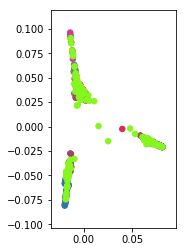

In [16]:
# your code goes here
print(labels)
mllab.pca.plot_toy_2d(data_normalized_reduced,labels)

#### Task 6: Comparison with the un-pre-processed data.

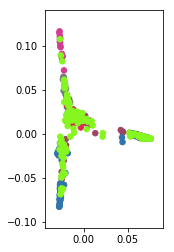

In [17]:
# your code goes here
mllab.pca.plot_toy_2d(data_reduced,labels)

### Comparison with other dimensionality reduction methods

#### Task 7: Compare diffusion maps with two other methods.

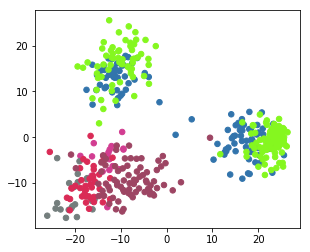

In [18]:
# your code goes here
pca = PCA(2)
mllab.pca.plot_toy_2d(pca.fit_transform(data_normalized),labels)

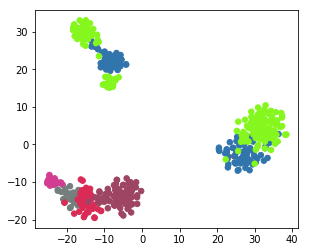

In [19]:
# your code goes here
mllab.pca.plot_toy_2d(TSNE(n_components=2).fit_transform(data_normalized),labels)

### Parameter selection

#### Task 8: Bandwidth comparison.

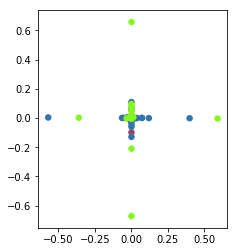

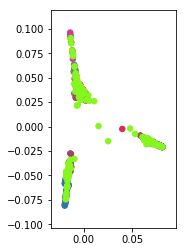

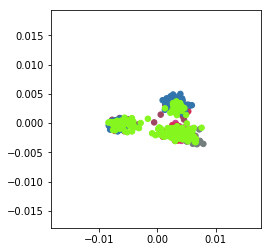

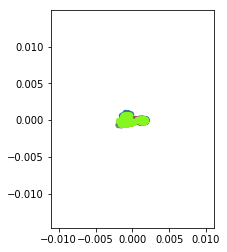

In [20]:
# your code goes here
for i in [5,10,50,100]:
    diffmap = DiffMap(n_components=2,sigma=i)
    data_normalized_reduced = diffmap.fit_transform(data_normalized)
    mllab.pca.plot_toy_2d(data_normalized_reduced,labels)
    

#### Task 9: Implement the rule for $\sigma$ and plot the embedding with the $\sigma$ chosen by this rule.

In [21]:
# your code goes here
distances = cdist(data_normalized,data_normalized, 'sqeuclidean')
distances = distances[~np.eye(distances.shape[0],dtype=bool)].reshape(distances.shape[0],-1)
max_distances = np.min(distances, axis = 1)
sigma = np.sqrt(np.sum(max_distances) / (2 * data_normalized.shape[0]))
print(sigma)

11.434125538288901


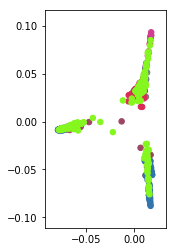

In [22]:
# your code goes here
diffmap = DiffMap(n_components=2,sigma=sigma)
data_normalized_reduced = diffmap.fit_transform(data_normalized)
mllab.pca.plot_toy_2d(data_normalized_reduced,labels)

### Cell group detection

Now, we want to apply spectral clustering to detect cell groups in the single-cell data.

#### Task 10: Implement the spectral clustering algorithm using k-means with $\Lambda$ as input.

In [23]:
# your code goes here
diffmap = DiffMap(sigma=sigma)
data_normalized_reduced = diffmap.fit_transform(data_normalized)


#### Task 11: Plot the first 20 eigenvalues of transition matrix $P$ for the Guo data and identify $\Lambda$.

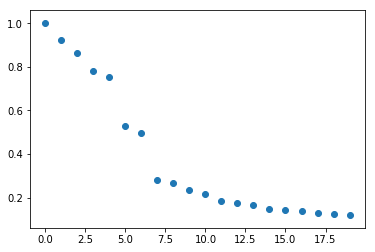

In [24]:
# your code goes here
plt.scatter(np.arange(20), diffmap.evals[:20])

#### Task 12: Perform the spectral clustering algorithm for the Guo data.

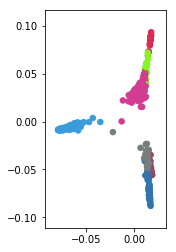

In [26]:
# your code goes here
predicted_labels = KMeans(n_clusters=7, random_state=0).fit_predict(data_normalized_reduced)
mllab.pca.plot_toy_2d(data_normalized_reduced[:,:2],predicted_labels)